In [1]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ, transpile, assemble
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
import numpy as np

from math import pi

In [2]:
def entropy(labels, base=2):
    value,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

In [3]:
provider = IBMQ.load_account()
#print(provider.backends())
backend = least_busy(provider.backends(simulator=False))
#backend = provider.get_backend('ibmq_armonk')
#backend = provider.get_backend('ibmq_quito')
print(backend)

ibmq_armonk


In [24]:
from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator.from_backend(backend)
backend = simulator

In [5]:
#Comment out to use real device
#from qiskit.test.mock import FakeArmonk
#backend = FakeArmonk()

In [6]:
n = backend.configuration().n_qubits
shots = backend.configuration().max_shots

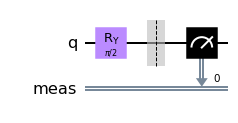

In [7]:
def get_circuit(n, thetas=None):
    if not thetas: thetas = [pi/2] * n
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.ry(thetas[i], i)
    qc.measure_all()
    return qc
qc = get_circuit(n)
qc.draw(output='mpl')

In [8]:
job = execute(qc, backend=simulator, shots=shots, memory=True)
job_monitor(job)

# Plotting our result
results = job.result().get_counts()
print(results)

Job Status: job has successfully run
{'0': 4239, '1': 3953}


In [9]:
e = entropy(job.result().get_memory())
print("results:", results)
print("entropy =", e)

results: {'0': 4239, '1': 3953}
entropy = 0.9991206029993307


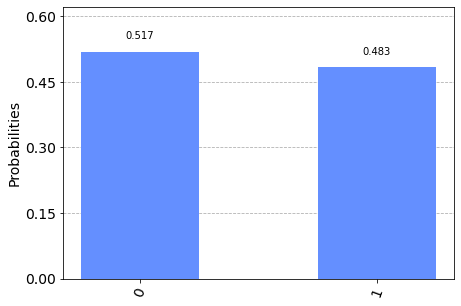

In [10]:
from qiskit.visualization import plot_histogram
plot_histogram(results)

In [11]:
def get_vals(results):
    vals = {}
    for v in results:
        for i, x in enumerate(v):
            if i not in vals: vals[i] = []
            vals[i] += [int(x)] * results[v]
    return vals
            
vals = get_vals(results)
print("0:", len(vals[0]) - sum(vals[0]), "1: ", sum(vals[0]))

0: 4239 1:  3953


In [12]:
backend

<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>

In [13]:
#job_manager = IBMQJobManager()
job_manager = None

In [14]:
def parse_results(results, n, k, circs_per_k):
    vals = {j: {} for j in range(n)} #creates a dictionary for results in format {qubit number: {circuit type: numbers}}
    
    for i in range(k * circs_per_k):
        a = i % k # originally, len(circs) = k, so when we multiply by circs_per_k, we will have indentical circuits every k'th index
        
        if a not in vals[0]:
            for j in range(n): vals[j][a] = []
        
        #print("\t For theta(s): ", i, thetas[i])
        res = results.get_memory(i)
        for j in range(n):
            vals[j][a] += [int(x[j]) for x in res]
    
    return vals
        
    
def get_entropies(vals, n, k, verbose=True):
    entropies = {j: (0, 0) for j in range(n)} #stores a tuple which is the best theta for each qubit
    for i in range(k):
        if verbose:
            differences = {j: sum(vals[j][i])/len(vals[j][i]) for j in range(n)}
            print(i, ": \t per qubit:", {j: {0: len(vals[j][i]) - sum(vals[j][i]), 1: sum(vals[j][i]), "ratio":differences[j]} for j in range(n)})
            print("\t (entropy, theta): ", end=" ")
        for j in range(n):
            e = entropy(vals[j][i])
            entropies[j] = max(entropies[j], (e, thetas[i][j])) #keeps track of best entropy so far and corresponding theta
            if verbose: print("(", e, thetas[i][j], end="),")
        
        if verbose: print("\n")

    return entropies

In [25]:
n_iterations = 20
progress = {j: [] for j in range(n)}
max_circuits = 75
k = 5 # choose k different values of theta for each qubit and compile into k different circuits
best_thetas = [pi/2] * n
delta = 0.01
for iteration in range(n_iterations):
    circs = []
    thetas = []
    
    circs_per_k = max_circuits//k
    for i in range(k):
        diff = i - k//2
        thetas.append([])
        for j in range(n):
            theta = best_thetas[j] + diff * delta
            thetas[i].append(theta)
        circ = get_circuit(n, thetas[i])
        circs.append(circ)
    circs *= circs_per_k
    #circs = transpile(circs, backend=backend)
    
    """if job_manager:
        print("\nrunning on job manager...")
        results = job_manager.run(circs, backend=backend, shots=shots).results()
    else:
        print("\nrunning with simulator...")
        results = [execute(c, backend=simulator, shots=shots).result() for c in circs]
    """
    print("running...")
    job = execute(circs, backend=backend, shots=shots, memory=True)
    results = job.result()
    

    print("\n\n On round", iteration, ": ")
    
    vals = parse_results(results, n, k, circs_per_k)
    
    #print(n, len(vals), k, len(vals[0]), len(vals[0][0]), sum(vals[0][0]))
    #print(1/0)
    entropies = get_entropies(vals, n, k)
    #
        
        
    print("\n updating best_thetas")
    
    for j in range(n):
        print("qubit", j, "had the best entropy of", entropies[j][0], "at theta=", entropies[j][1])
        best_thetas[j] = entropies[j][1]
        progress[j].append(entropies[j][0])
    delta = delta/((k-1)/2)
    
print("\n\nFinished!: ", entropies)

running...


 On round 0 : 
0 : 	 per qubit: {0: {0: 63827, 1: 59053, 'ratio': 0.48057454427083335}}
	 (entropy, theta):  ( 0.99891092880106 1.5507963267948965),

1 : 	 per qubit: {0: {0: 63242, 1: 59638, 'ratio': 0.48533528645833335}}
	 (entropy, theta):  ( 0.9993793968380651 1.5607963267948965),

2 : 	 per qubit: {0: {0: 62444, 1: 60436, 'ratio': 0.4918294270833333}}
	 (entropy, theta):  ( 0.9998073677998363 1.5707963267948966),

3 : 	 per qubit: {0: {0: 61921, 1: 60959, 'ratio': 0.4960856119791667}}
	 (entropy, theta):  ( 0.9999557883504999 1.5807963267948966),

4 : 	 per qubit: {0: {0: 61239, 1: 61641, 'ratio': 0.5016357421875}}
	 (entropy, theta):  ( 0.9999922796850316 1.5907963267948966),


 updating best_thetas
qubit 0 had the best entropy of 0.9999922796850316 at theta= 1.5907963267948966
running...


 On round 1 : 
0 : 	 per qubit: {0: {0: 61863, 1: 61017, 'ratio': 0.4965576171875}}
	 (entropy, theta):  ( 0.9999658078590611 1.5807963267948966),

1 : 	 per qubit: {0: {0: 61476,



 On round 11 : 
0 : 	 per qubit: {0: {0: 61586, 1: 61294, 'ratio': 0.49881184895833336}}
	 (entropy, theta):  ( 0.9999959266826268 1.5885014049198967),

1 : 	 per qubit: {0: {0: 61493, 1: 61387, 'ratio': 0.49956868489583334}}
	 (entropy, theta):  ( 0.999999463222971 1.5885062877323965),

2 : 	 per qubit: {0: {0: 61681, 1: 61199, 'ratio': 0.4980387369791667}}
	 (entropy, theta):  ( 0.9999889011667109 1.5885111705448967),

3 : 	 per qubit: {0: {0: 61450, 1: 61430, 'ratio': 0.4999186197916667}}
	 (entropy, theta):  ( 0.9999999808908164 1.5885160533573968),

4 : 	 per qubit: {0: {0: 61406, 1: 61474, 'ratio': 0.5002766927083333}}
	 (entropy, theta):  ( 0.9999997790978283 1.5885209361698966),


 updating best_thetas
qubit 0 had the best entropy of 0.9999999808908164 at theta= 1.5885160533573968
running...


 On round 12 : 
0 : 	 per qubit: {0: {0: 61618, 1: 61262, 'ratio': 0.49855143229166665}}
	 (entropy, theta):  ( 0.9999939454378526 1.5885111705448967),

1 : 	 per qubit: {0: {0: 61341, 

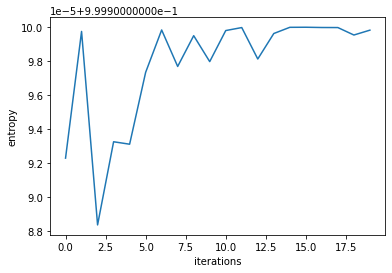

In [26]:
import matplotlib.pyplot as plt

if n > 1:  
    figs, axs = plt.subplots(round(n/2) + 1, 2, figsize=(10, 10))

    for i in range(n):
        axs[i//2, i%2].plot(range(n_iterations), progress[i])
        axs[i//2, i%2].set_xlabel("iterations")
        axs[i//2, i%2].set_ylabel("entropy")
        axs[i//2, i%2].set_title("Entropy for qubit " + str(i))

else:
    plt.plot(range(n_iterations), progress[0])
    #plt.title("entropy")
    plt.xlabel("iterations")
    plt.ylabel("entropy")
    
